# CNN Autoencoder for Image Reconstruction

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import kagglehub as kh

##Downloading the dataset from kaggle

In [31]:
os.makedirs("data", exist_ok=True)
kh.dataset_download("codebreaker619/columbia-university-image-library")

'/root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1'

##Load and Preprocess Dataset

In [32]:
def load_data(directory):
    """Load images from the extracted directory and normalize them."""
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    data_gen = datagen.flow_from_directory(
        directory,
        target_size=(128, 128),
        color_mode='grayscale',
        class_mode=None,
        batch_size=10000,
        shuffle=False
    )
    images = next(data_gen)
    return images

In [33]:
images = load_data("/root/.cache/kagglehub/datasets/codebreaker619/columbia-university-image-library/versions/1/coil-20")

Found 1800 images belonging to 2 classes.


##Splitting the dataset

In [34]:
# Inspect the dataset
print(f"Total images loaded: {images.shape[0]}")
print(f"Image shape: {images.shape[1:]}")

# Shuffle and split the dataset
X_train, X_test = train_test_split(images, test_size=0.2, random_state=42)

# Confirm split
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Total images loaded: 1800
Image shape: (128, 128, 1)
Training set size: 1440
Testing set size: 360


##CNN Autoencoder

In [35]:
# Encoder
input_img = Input(shape=(128, 128, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Latent Space
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

## Compile the Model

In [36]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the Model

In [37]:
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 0.0723 - val_loss: 0.0093
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0065 - val_loss: 0.0051
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0

##Evaluate the Model

In [38]:
# Calculate Test MSE
X_test_pred = autoencoder.predict(X_test)
test_mse = mean_squared_error(X_test.flatten(), X_test_pred.flatten())

print(f"Final Test MSE: {test_mse}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Final Test MSE: 0.002125301631167531


The MSE value (~0.0022) is quite low, suggesting that the autoencoder is performing well in reconstructing the images.

The reconstructed images closely resemble the original images, with minimal pixel-wise differences.

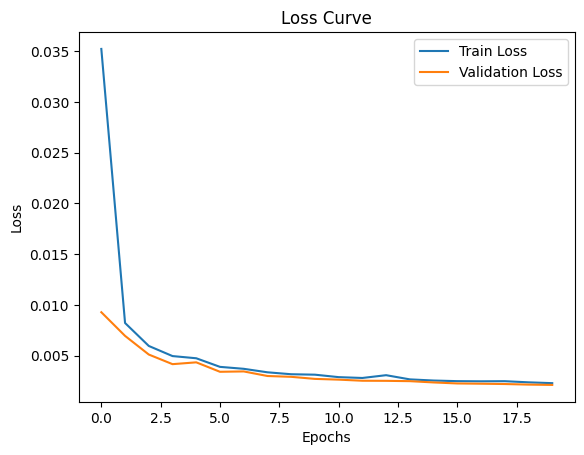

In [39]:
# Visualize Loss Curve
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The model has learned a good representation of the data with minimal overfitting.

While the loss is very low, further tuning (e.g., more epochs or architectural adjustments) might yield marginal improvements.

The small gap between training and validation losses indicates strong generalization.

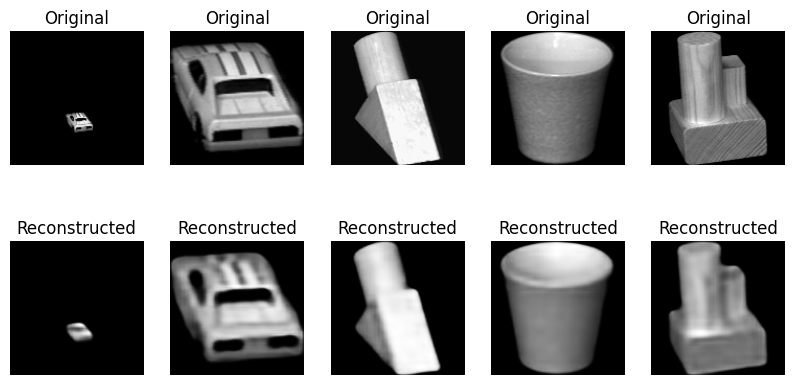

In [40]:
#Visualize Original and Reconstructed Images
n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + n + 1)
    plt.imshow(X_test_pred[i].squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()


The model gives strong reconstruction capabilities for the dataset, retaining the structure and visual details of the objects.